In [1]:
from random import seed
from random import random
from random import randrange
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})
sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# 1. Bootstrap

In [3]:
#TODO
# Create a random subsample from the dataset with replacement
def subsample(X,y, ratio=0.8):
    
    # pick a random subsample of X and the corresponding y
    num_of_instances = X.shape[0]
    indices = np.random.randint(num_of_instances, size=round(num_of_instances*ratio))
    sample_X, sample_y = X[indices,:], y[indices]
    return sample_X, sample_y

In [4]:
#TODO
# Bootstrap Aggregation Algorithm
def bagging(X_train, y_train, X_test, n_clfs, Classifier):
    clfs = list()
    for i in range(n_clfs):
        # train the clfs on the train subsamples with random_state = seed and add them to the list
        Classifier.random_state = seed
        features, labels = subsample(X_train,y_train)
        clfs.append(Classifier().fit(features, labels))
    
    index = 0
    y_ = [None] * X_test.shape[0]
    for row in X_test:
        row = row.reshape(1,-1)
        # predict for each of the classifiers
        predicted_y =  list()
        for i in range(0, len(clfs)):
            predicted_y.append(int(clfs[i].predict(row))) # int classes
        #pick the prediction with the highest number
        temp = np.argmax(np.bincount(predicted_y))
        y_[index] = temp
        index = index + 1
                    
    return(y_)

In [5]:
def KFold_split(X, y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    y_train_folds = []
    y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        y_train_folds.append(y[kth_fold_train_idxs])
        y_val_folds.append(y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, y_train_folds, y_val_folds

In [6]:
#TODO
def evaluate_algorithm(X_train_val, y_train_val, num_folds, seed, algorithm, *args):
    # Extract train and validation folds:
    X_train_folds, X_val_folds, y_train_folds, y_val_folds = KFold_split(X_train_val, y_train_val, num_folds, seed)
    scores = list()
    
    for X_train_fold, X_val_fold, y_train_fold, y_val_fold in zip(X_train_folds, X_val_folds
                                                                  , y_train_folds, y_val_folds):
        predictions = algorithm(X_train_fold, y_train_fold, X_val_fold, *args)
        scores.append(accuracy_score(y_val_fold, predictions))#compute the accuracy
    return scores

In [7]:

# Test bagging on the sonar dataset
seed = 2
# load and prepare data
filename = 'sonar.all-data'
dataset = pd.read_csv(filename,header=None)
X = dataset.iloc[:,:-1].to_numpy()
y = (dataset.iloc[:,-1].to_numpy()=='M').astype(int)
# evaluate algorithm
num_folds = 5
sample_size = 0.8
random.seed(seed)
# Extract a test set:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=seed)




# For each hyper-parameter instance, do KFold cross validation:
for n_trees in [10, 50, 100, 150, 200]:
    scores = evaluate_algorithm(X_train_val, y_train_val, num_folds, seed, bagging, n_trees, DecisionTreeClassifier) #compute scores for the n_trees
    print('Trees: %d' % n_trees)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f' % (sum(scores)/float(len(scores))))
    



Trees: 10
Scores: [0.7241379310344828, 0.7931034482758621, 0.7241379310344828, 0.6896551724137931, 0.7586206896551724]
Mean Accuracy: 0.738
Trees: 50
Scores: [0.8620689655172413, 0.7586206896551724, 0.8275862068965517, 0.7931034482758621, 0.7241379310344828]
Mean Accuracy: 0.793
Trees: 100
Scores: [0.7586206896551724, 0.7931034482758621, 0.7586206896551724, 0.7931034482758621, 0.6896551724137931]
Mean Accuracy: 0.759
Trees: 150
Scores: [0.7931034482758621, 0.7931034482758621, 0.8275862068965517, 0.8275862068965517, 0.6896551724137931]
Mean Accuracy: 0.786
Trees: 200
Scores: [0.7586206896551724, 0.7586206896551724, 0.7586206896551724, 0.8275862068965517, 0.6896551724137931]
Mean Accuracy: 0.759


In [8]:
Best_n = 50
print('Test set Accuracy: %.3f' %(accuracy_score(bagging(X_train_val,y_train_val,X_test,Best_n
                                                             ,DecisionTreeClassifier),y_test)))

Test set Accuracy: 0.794


# 2. Missing numerical values

In [9]:
def load_diabetes():
    dataset = pd.read_csv('pima-indians-diabetes.csv', header=None)
    print(dataset.describe())
    return dataset

In [10]:
# print the first 20 rows of data
dataset = load_diabetes()
print(dataset.head(20))

                0           1           2           3           4           5  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

                6           7           8  
count  768.000000  768.000000  768.000000  
mean     0.471876   33.240885    0.348958  
std      0.331329   11.760232    0.476951  
min      0.078000   21.000000    0.000000  
25%      0.243750   24.000000    0.000000  
50%   

In [11]:
#TODO
#Count the number of zero values in column indeces [1,2,3,4,5]
num_of_zeros = [None] * 5
for i in [1,2,3,4,5]:
    thelist = dataset.values[:,i].tolist()
    frequencies = np.array(np.unique(thelist, return_counts=True)).T
    index = np.where(frequencies[:,0] == 0)
    if index[0].size != 0:
        num_of_zeros[i-1] = int(frequencies[index[0],1])
print(num_of_zeros)

[5, 35, 227, 374, 11]


In [12]:
#TODO
# mark zero values as missing or NaN
for i in [1,2,3,4,5]:
    for j in range(dataset.values.shape[0]):
        if dataset.values[j,i]==0:
            dataset[i][j] = np.nan
# count the number of NaN values in each column
print(dataset.isnull().sum())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Amin\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0      0
1      5
2     35
3    227
4    374
5     11
6      0
7      0
8      0
dtype: int64


In [13]:
dataset.head(20)

,0,1,2,3,4,5,6,7,8
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,NaN,NaN,NaN,0.232,54,1


In [14]:
#TODO
#delete rows contating NAN values from the dataset using .dropna(inplace = True) built-in function
# print (dataset.shape)
dataset.dropna(inplace=True)
print (dataset.shape)

(392, 9)


In [15]:
values = dataset.values
X = values[:,0:8]
y = values[:,8]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=seed)


In [16]:
#TODO
#complete the function to 
#evaluate the MLP model on the test set
def evaluate_MLP(X_train, y_train,X_valid,y_valid,seed=7):
    model = MLPClassifier()
    model.fit(X_train, y_train)
    result = model.predict(X_valid)
    print(accuracy_score(result,y_valid))

In [17]:
evaluate_MLP(X_train, y_train,X_valid,y_valid,7)

0.42857142857142855


In [18]:
dataset = load_diabetes()
#TODO
# Mark zero values of column indices [1,2,3,4,5] as missing or NaN
for i in [1,2,3,4,5]:
    for j in range(dataset.values.shape[0]):
        if dataset.values[j,i]==0:
            dataset[i][j] = np.nan
# This time fill missing values with mean column values using .fillna(dataset.mean(),inplace=True)
dataset.fillna(dataset.mean(),inplace=True)
# count the number of NaN values in each column
print(dataset.isnull().sum())

                0           1           2           3           4           5  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

                6           7           8  
count  768.000000  768.000000  768.000000  
mean     0.471876   33.240885    0.348958  
std      0.331329   11.760232    0.476951  
min      0.078000   21.000000    0.000000  
25%      0.243750   24.000000    0.000000  
50%   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Amin\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64


In [19]:
dataset.head(20)

,0,1,2,3,4,5,6,7,8
0,6,148.0,72.000000,35.00000,155.548223,33.600000,0.627,50,1
1,1,85.0,66.000000,29.00000,155.548223,26.600000,0.351,31,0
2,8,183.0,64.000000,29.15342,155.548223,23.300000,0.672,32,1
3,1,89.0,66.000000,23.00000,94.000000,28.100000,0.167,21,0
4,0,137.0,40.000000,35.00000,168.000000,43.100000,2.288,33,1
5,5,116.0,74.000000,29.15342,155.548223,25.600000,0.201,30,0
6,3,78.0,50.000000,32.00000,88.000000,31.000000,0.248,26,1
7,10,115.0,72.405184,29.15342,155.548223,35.300000,0.134,29,0
8,2,197.0,70.000000,45.00000,543.000000,30.500000,0.158,53,1
9,8,125.0,96.000000,29.15342,155.548223,32.457464,0.232,54,1


In [20]:
values = dataset.values
X = values[:,0:8]
y = values[:,8]
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=seed)


In [21]:
X_train.shape

(576, 8)

In [22]:
evaluate_MLP(X_train, y_train,X_valid,y_valid,7)

0.6938775510204082


# 3. Imbalanced Data

In [23]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
print(df.Class.value_counts())

0    284315
1       492
Name: Class, dtype: int64


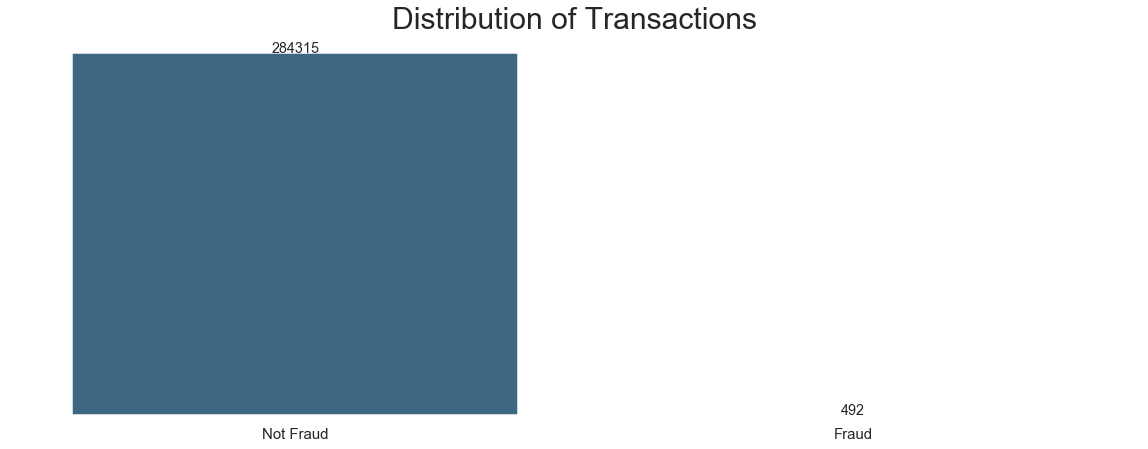

In [25]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(df.Class, palette='viridis')
g.set_xticklabels(['Not Fraud', 'Fraud'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [26]:
# TODO
# print percentage of samples where target == 1
df.Class.value_counts()[1]/df.Class.value_counts()[0]

0.0017304750013189597

In [27]:
# Prepare data for modeling
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up validation and training sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=27)

In [28]:
#TODO
# Train a DummyClassifier to predict with 'most_frequent' strategy
dummy = DummyClassifier()
dummy.fit(X_train,y_train)
dummy_pred = dummy.predict(X_valid)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Validation score: ', accuracy_score(y_valid, dummy_pred))

Unique predicted labels:  [0 1]
Validation score:  0.9965590854189489


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py:227: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  k in range(self.n_outputs_)).T


In [29]:
def evaluate_imbalanced(y_valid, lr_pred):
    # Checking accuracy
    print('Accuracy: ', accuracy_score(y_valid, lr_pred))
    #recall score
    print('Recall: ',recall_score(y_valid, lr_pred))
    #precision score
    print('Precision: ', precision_score(y_valid, lr_pred))
    # f1 score
    print('F1 score: ',f1_score(y_valid, lr_pred))
    # confusion matrix
    print('ConfMat')
    print(pd.DataFrame(confusion_matrix(y_valid, lr_pred)))

In [30]:
#TODO
# Train a LogisticRegressio model with solver as 'liblinear' on the training data
lr = LogisticRegression()
lr.fit(X_train, y_train)
 
# Predict on validation set
lr_pred = lr.predict(X_valid)

In [31]:
evaluate_imbalanced(y_valid, lr_pred)

Accuracy:  0.9992135052386169
Recall:  0.6439393939393939
Precision:  0.9042553191489362
F1 score:  0.7522123893805309
ConfMat
       0   1
0  71061   9
1     47  85


In [32]:
from sklearn.utils import resample

In [33]:
y = df.Class
X = df.drop('Class', axis=1)

# setting up validation and training sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=27)

In [34]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,161634.0,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,...,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,2.74,0
163821,116237.0,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,...,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,38.44,0
72083,54557.0,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,...,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,1.00,0
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.89,0
126213,77959.0,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,...,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,237.00,0


In [35]:
# TODO
# separate minority and majority classes
not_fraud =  pd.DataFrame(df, index=np.where(df.values[:,-1] == 0)[0])
fraud = pd.DataFrame(df, index=np.where(df.values[:,-1] == 1)[0])

# upsample minority using resample and n_samples equal to the size of majority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=not_fraud.shape[0], # match number in majority class
                          random_state=27) # reproducible result


# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

1    284315
0    284315
Name: Class, dtype: int64

In [36]:
#TODO
# trying logistic regression again with the balanced dataset
y = upsampled.Class
X = upsampled.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
# y_train = ...
# X_train = ...

# Train a logistic regression with solver 'liblinear' on the train data
upsampled = LogisticRegression(solver='liblinear')
upsampled.fit(X_train, y_train)
# predict on the test data
upsampled_pred = upsampled.predict(X_test)

In [37]:
evaluate_imbalanced(y_test, upsampled_pred)

Accuracy:  0.9379563584180982
Recall:  0.9023495685899778
Precision:  0.9716875491798317
F1 score:  0.9357358320096761
ConfMat
       0      1
0  69125   1871
1   6949  64213


In [38]:
# still using our separated classes fraud and not_fraud from above
# TODO
# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = fraud.shape[0], # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

In [39]:
# TODO
# trying logistic regression again with the undersampled dataset
y = downsampled.Class
X = downsampled.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
# X_train = ...
# y_train = ...

# Train a logistic regression with solver 'liblinear' on the train data
undersampled = LogisticRegression(solver='liblinear')
undersampled.fit(X_train, y_train)
undersampled_pred = undersampled.predict(X_test)

In [40]:
evaluate_imbalanced(y_test, undersampled_pred)

Accuracy:  0.9512195121951219
Recall:  0.8983050847457628
Precision:  1.0
F1 score:  0.9464285714285715
ConfMat
     0    1
0  128    0
1   12  106


In [41]:
from sklearn.ensemble import RandomForestClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [42]:
df = pd.read_csv('creditcard.csv')
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [43]:
# train a random forest model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
# predict on test set
rfc_pred = rfc.predict(X_test)

In [44]:
evaluate_imbalanced(y_test,rfc_pred)

Accuracy:  0.9995786635206876
Recall:  0.803030303030303
Precision:  0.9636363636363636
F1 score:  0.8760330578512396
ConfMat
       0    1
0  71066    4
1     26  106
